I will use this notebook to demonstrate some calculations of photon emission properties from a nanofiber-trapped neutral atom system using MEEP and plotting in Julia.

In [1]:
run(pipeline(`mpirun -n 6 meep-mpi "nanofiber_2d.ctl"`, "nanofiber_2d.out"))


Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecate

# Local field evolution

This should be obtained by setting up a point-monitor at the dipole position and append time-dependent field components in some short periods. 
The data is stored in the `nanofiber-Ert.h5` file.
Now we plot out the time-dependent evolution of the field at the dipole position.

In [2]:
run(`h5ls nanofiber_2d-Ert.h5`)

ex.i                     Dataset {60000/Inf}
ex.r                     Dataset {60000/Inf}
ey.i                     Dataset {60000/Inf}
ey.r                     Dataset {60000/Inf}
ez.i                     Dataset {60000/Inf}
ez.r                     Dataset {60000/Inf}


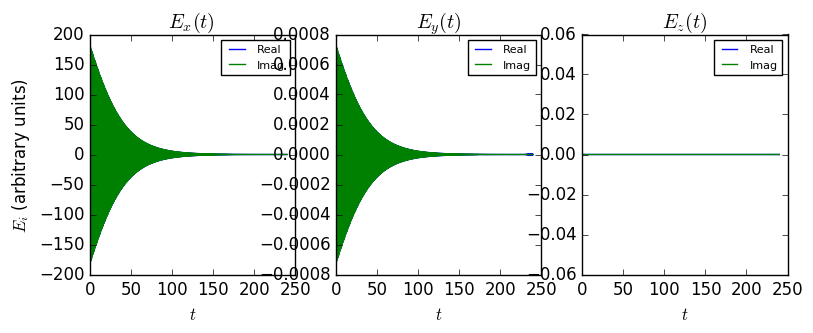

1
(60000,)


PyObject <matplotlib.legend.Legend object at 0x7f5268ca2b10>

In [3]:
using PyPlot
using HDF5
ex = h5read("nanofiber_2d-Ert.h5", "ex.r") + im*h5read("nanofiber_2d-Ert.h5", "ex.i")
ey = h5read("nanofiber_2d-Ert.h5", "ey.r") + im*h5read("nanofiber_2d-Ert.h5", "ey.i")
ez = h5read("nanofiber_2d-Ert.h5", "ez.r") + im*h5read("nanofiber_2d-Ert.h5", "ez.i")
println(ndims(ex)) # Print out the dimension of the variables to check if it's a vector (output 1). Otherwise, use permutedims to flip the data dimension.
ex = ex[end:-1:1]; ey = ey[end:-1:1]; ez = ez[end:-1:1];
println(size(ex))
lent=length(ex)
dt=240.0/(lent-0.0)
println(dt)
t=linspace(0,240.0,lent)+dt/2.0
figure(figsize=(9,3))
subplot(1,3,1)
ax=plot(t,real(ex))
plot(t,imag(ex))
title("\$E_x(t)\$ ")
xlabel(L"t")
ylabel(L"$E_i$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,2)
ax=plot(t,real(ey))
plot(t,imag(ey))
title("\$E_y(t)\$")
xlabel(L"t")
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,3)
ax=plot(t,real(ez))
plot(t,imag(ez))
title("\$E_z(t)\$")
xlabel(L"t")
#ylabel(L"$E_z$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

Now we can plot out the detected signal in the frequency domain correspondingly.

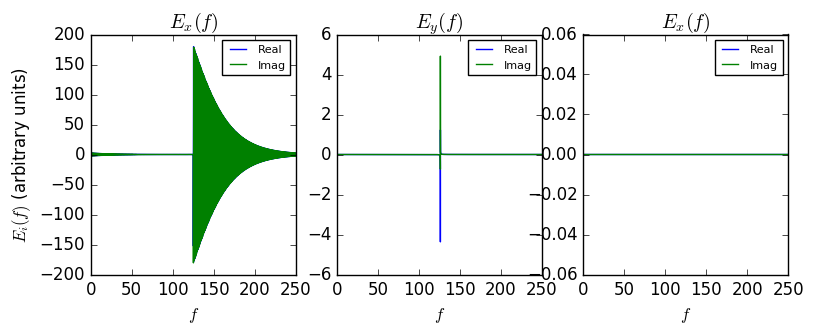

(60000,)


PyObject <matplotlib.legend.Legend object at 0x7f526205c6d0>

In [29]:
#nUniquePts = ceil(Int, (lent+1)/2); # Nuquist sampling points of data.
ex_f=fft(ex); ey_f=fft(ey); ez_f=fft(ez);
ex_f=fftshift(ex); ey_f=fftshift(ey_f); ez_f=fftshift(ez_f); # Have to shift the frequency domain data for complex singal. See: http://www.exegetic.biz/blog/2015/10/monthofjulia-day-37-fourier-techniques/ 

freq = (1.0/dt)*(0:(lent-1))/lent;
println(size(freq))
figure(figsize=(9,3))
subplot(1,3,1)
plot(freq,real(ex_f))
plot(freq,imag(ex_f))
xlabel(L"f")
#xlim([400,960])
ylabel(L"$E_i(f)$ (arbitrary units)")
title("\$E_x(f)\$")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,2)
plot(freq,real(ey_f))
plot(freq,imag(ey_f))
xlabel(L"f")
#xlim([800,960])
#xticks(linspace(800,960,5))
title("\$E_y(f)\$")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,3)
plot(freq,real(ez_f))
plot(freq,imag(ez_f))
xlabel(L"f")
#xlim([800,960])
#xticks(linspace(800,960,5))
title("\$E_x(f)\$")
legend(["Real", "Imag"],fontsize=8)

It becomes tricky now to tranvert the unit of frequency in MEEP to a normal scale. I am not sure about this part for now. See the dipole signal below.

## The time-evolution of the dipole source
To calculate the Green function at the dipole position, we need to use the time-evolution of the dipole source which is essentially described by the following function
$$E_i = E_0 \exp{\left[-i\omega t-\frac{(t-t_0)^2}{2w^2}\right]},$$
where $w=\frac{1}{df}$ is the time width of the signal and $df$ is the frequency width in the special units defined by MEEP. In the simulation script, the center of time $t_0$ is defined by 
$t_0=t_{start}+\Delta t_{cutoff}$ with the starting time $t_{start}=0$ and the cutoff time $t_{cutoff}=5$ by default. So, the signal of the input component will look like the following.

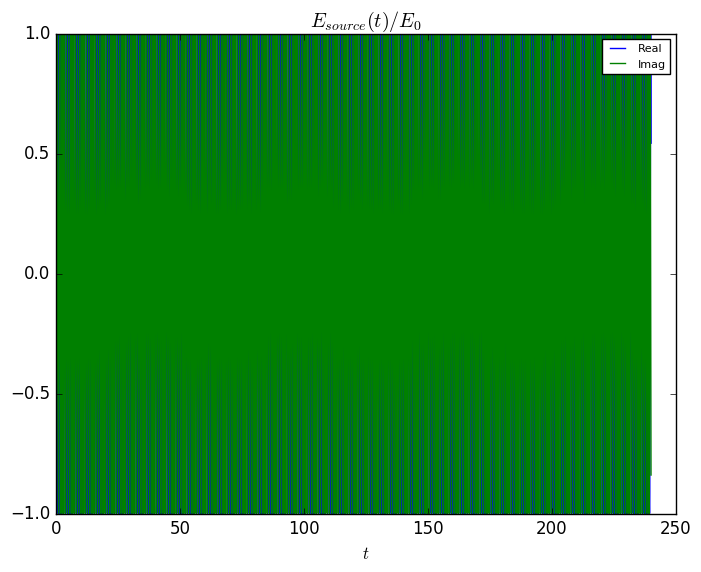

PyObject <matplotlib.legend.Legend object at 0x7f5268032c90>

In [5]:
df=0.02; w=1/df;
ω=2.*pi/0.895 # in MEEP, we have c=1, lambda=0.895.
t_cutoff=5; t_0=t_cutoff;
#E_source=exp(-im*ω*t-(t-t_0).^2/2./w^2) # A Gaussian source.
E_source=exp(-im*ω*t) # Continuous source.
figure;
plot(t,real(E_source))
plot(t,imag(E_source))
title("\$E_{source}(t)/E_0\$")
xlabel(L"t")
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

Now, let's look at the signal in the frequency domain.

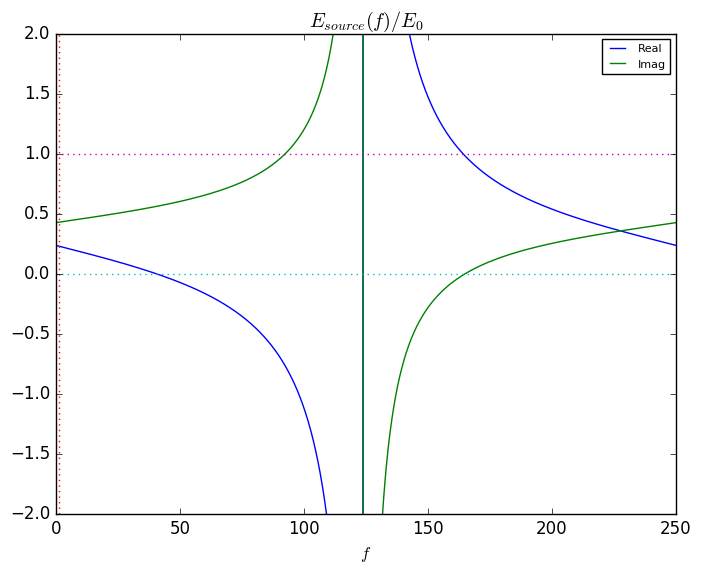

1.1173184357541899


PyObject <matplotlib.legend.Legend object at 0x7f5261ea4890>

In [30]:
E_source_f = fft(E_source)
E_source_f = fftshift(E_source_f) # Shift the data as before.
figure;
plot(freq,real(E_source_f))
plot(freq,imag(E_source_f))
plot([ω/2./pi,ω/2./pi], [-2., 2.],linestyle=":")
plot([0,1200],[0,0],linestyle=":")
plot([0,1200],[1,1],linestyle=":")
println(1/0.895)
title("\$E_{source}(f)/E_0\$")
xlabel(L"f")
xlim([0,freq[end]])
#ylabel(L"$E_y$ (arbitrary units)")
ylim([-2.,2.])
legend(["Real", "Imag"],fontsize=8)

Again, to convert the unit of frequency to the normal scale becomes tricky. I need to think about it more carefully. 

Also, I didn't use the `fftshift()` function for this transformation, in which I should. The signal in MEEP is a complex function and is different from many other software. 

To be continued...

## The Green's function and decay rates
We can calculate the Green's function in the frequency domain using the detected field and signal components obtained earlier. Only the imaginary part is related to us, and the Green's function we can obtain is normalized to the dipole excited in free space.

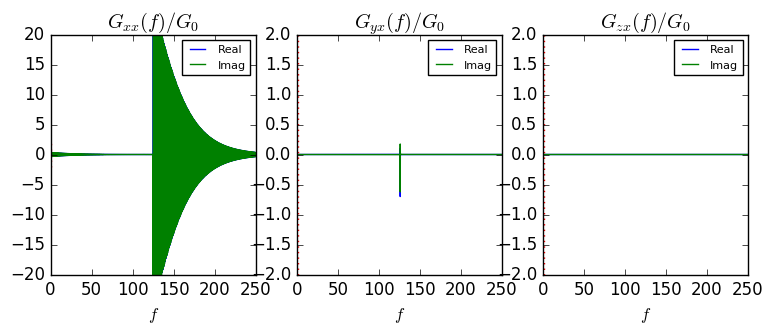

PyObject <matplotlib.legend.Legend object at 0x7f5261cfd490>

In [31]:
Gxx=im*ex_f./ω #im*ex_f./E_source_f/ω
Gyx=im*ey_f./ω #im*ey_f./E_source_f/ω
Gzx=im*ez_f./ω #im*ez_f./E_source_f/ω

figure(figsize=(9,3))
subplot(1,3,1)
plot(freq,real(Gxx))
plot(freq,imag(Gxx))
plot([ω/2./pi,ω/2./pi], [-2., 2.],linestyle=":")
title("\$G_{xx}(f)/G_0\$")
xlabel(L"f")
#xlim([750,880])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{xx}/G_0$ (arbitrary units)")
ylim([-20,20])
legend(["Real", "Imag"],fontsize=8)
#legend(["Imag"],fontsize=8)

subplot(1,3,2)
plot(freq,real(Gyx))
plot(freq,imag(Gyx))
plot([ω/2./pi,ω/2./pi], [-2., 2.],linestyle=":")
title("\$G_{yx}(f)/G_0\$")
xlabel(L"f")
#xlim([750,880])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{yx}/G_0$ (arbitrary units)")
#ylim([-2,2])
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,3)
plot(freq,real(Gzx))
plot(freq,imag(Gzx))
plot([ω/2./pi,ω/2./pi], [-2., 2.],linestyle=":")
title("\$G_{zx}(f)/G_0\$")
xlabel(L"f")
#xlim([750,880])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{zx}/G_0$ (arbitrary units)")
#ylim([-2,2])
legend(["Real", "Imag"],fontsize=8)